# PROMPTS

In [3]:
INFO_TEXT_ONLY_SYSTEM_PROMPT = """You are an AI model that classifies text into one of two categories based on its informational value. Your task is to analyze the given text and determine whether it contains relevant or informative content about a crisis.\\n\\nOur goal is to collect as much useful information as possible about crises, so your classification should prioritize identifying texts that provide relevant details, even if they are brief or incomplete. Avoid being overly restrictive. If a text has any relevant crisis-related information, classify it as informative.\\n\\nClassify the text delimited by triple quotes (\"\"\" \"\"\") into one of the following categories:\\n\\n- **1 (positive):** The text provides details, updates, or any relevant information about a crisis.\\n\\n- **0 (not positive):** The text does not contain relevant details or information about a crisis.\\n\\nReturn only the classification label (1 or 0) without any extra text or explanation."""

INFO_TEXT_ONLY_USER_PROMPT = """
    Classify the text delimited by triple quotes (\"\"\" \"\"\") into one of the two categories:  
        - 1 if the text provides details, updates, or any relevant information about a crisis.  
        - 0 if the text does not contain relevant details or information about a crisis.
"""

INFO_IMAGE_ONLY_SYSTEM_PROMPT = """You are an AI model that classifies the given text and image into one of two categories based on its informational value. Your task is to analyze the given text and image to determine whether they contains relevant or informative content about a crisis.\\n\\nOur goal is to collect as much useful information as possible about crises, so your classification should prioritize identifying texts and image that provide relevant details, even if they are brief or incomplete. Avoid being overly restrictive. If the text and image have any relevant crisis-related information, classify them as informative.\\n\\nClassify the text delimited by triple quotes (\"\"\" \"\"\") and the given image into one of the following categories:\\n\\n- **1 (positive):** The text and image provide details, updates, or any relevant information about a crisis.\\n\\n- **0 (not positive):** The text and image do not contain relevant details or information about a crisis.\\n\\nReturn only the classification label (1 or 0) without any extra text or explanation."""

INFO_IMAGE_ONLY_USER_PROMPT = """You are an AI model that classifies the given text and image into one of two categories based on its informational value. Your task is to analyze the given text and image to determine whether they contains relevant or informative content about a crisis.\\n\\nOur goal is to collect as much useful information as possible about crises, so your classification should prioritize identifying texts and image that provide relevant details, even if they are brief or incomplete. Avoid being overly restrictive. If the text and image have any relevant crisis-related information, classify them as informative.\\n\\nClassify the text delimited by triple quotes (\"\"\" \"\"\") and the given image into one of the following categories:\\n\\n- **1 (positive):** The text and image provide details, updates, or any relevant information about a crisis.\\n\\n- **0 (not positive):** The text and image do not contain relevant details or information about a crisis.\\n\\nReturn only the classification label (1 or 0) without any extra text or explanation."""


INFO_TEXT_IMAGE_SYSTEM_PROMPT = """Classify the text delimited by triple quotes (\"\"\" \"\"\") in combination with the given image for crisis management. Determine if they provide important information that could help during a crisis.\\nReturn only a single classification label:\\n  1 if the text and image together provide useful crisis-related information.\\n  0 if the text and image together do not provide useful crisis-related information.\\nDo not include any extra text or explanation in your response."""

INFO_TEXT_IMAGE_USER_PROMPT = """
    Classify the following text delimited by triple quotes (\"\"\" \"\"\") and image into one of the two categories:  
        - 1 if the text and image provides details, updates, or any relevant information about a crisis.  
        - 0 if the text and image does not contain relevant details or information about a crisis.
"""

# GPT FEW SHOTS IMPLEMENTATIONS

In [4]:
import json
import pandas as pd
from openai import OpenAI
import time
import sys
import os

# Set up OpenAI API key
client = OpenAI(api_key="your-API-key")


In [5]:
import os
import json
import time
import random
import openai
import base64
from collections import defaultdict
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Function to encode the image
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

def ensure_path_exists(file_path):
    """
    Ensure that the directory for the given file path exists. Create it if it doesn't.
    """
    directory = os.path.dirname(file_path)
    if directory and not os.path.exists(directory):
        os.makedirs(directory)

def update_remaining_time(start_time, current_index, total_tests, milestone_desc):
    """
    Prints an estimated remaining time for the test process.

    :param start_time: the time when the testing started (time.time())
    :param current_index: current test item index (1-based)
    :param total_tests: total number of test items
    :param milestone_desc: string describing the milestone, e.g. "25% of tests"
    """
    elapsed = time.time() - start_time
    tests_done = current_index
    if tests_done == 0:
        return

    tests_left = total_tests - tests_done
    # Estimated total time if the average up to now continues
    time_per_test = elapsed / tests_done
    estimated_remaining = tests_left * time_per_test

    mins, secs = divmod(estimated_remaining, 60)
    hours, mins = divmod(mins, 60)

    print(f"\n📊--- Reached {milestone_desc} ---📊")
    print(f"    Elapsed time: {elapsed:.2f} seconds for {tests_done} items.")
    print(f"    Estimated time left: {int(hours)}h:{int(mins)}m:{int(secs)}s for {tests_left} items.\n")
    

def get_few_shot_examples(devdata, few_shot_num, consistency, label_key="label"):
    """
    Extract few-shot examples from the development set.
    Each label's entry is a list of dicts with just "text" and "image_path".

    :param devdata: a list of dictionaries, each dict containing at least {"text", "label", "image_path"}
    :param few_shot_num: how many examples per class to retrieve
    :param consistency: if True, the same examples (randomly selected once) 
                        will be reused for all test items. 
                        If False, for each test item, we sample again from the dev set.
    :param label_key: dictionary key for the label in dev data

    :return: a dictionary:
       {
            label_value_1: [ { 'text': ..., 'image_path': ..., 'label': ... }, ... ],
            label_value_2: [...],
            ...
       }
       Each list has up to `few_shot_num` items for that label.
    """

    # First, group dev entries by label.
    grouped_by_label = defaultdict(list)
    for item in devdata:
        lbl = item[label_key]
        grouped_by_label[lbl].append({
            "text": item["text"],
            "image_path": item["image_path"],
            "label": lbl 
        })

    # For each label, shuffle once (so that we can consistently pick the top `few_shot_num`).
    # We'll store them so that if consistency=True, we reuse them for all test items.
    # If consistency=False, we’ll sample anew inside the main loop.
    few_shot_pool = {}
    for lbl, items in grouped_by_label.items():
        random.shuffle(items)
        few_shot_pool[lbl] = items[:few_shot_num]

    return few_shot_pool

def build_few_shot_classification_chat(
    system_content,
    user_prompt_instructions,
    few_shot_examples,
    final_text=None,
    final_image_path=None,
    use_text=True,
    use_image=True
):
    """
    Builds a chat message list for classification using few-shot examples.
    
    :param system_content: system message content (str), e.g. "You are a helpful classifier..."
    :param user_prompt_instructions: the classification instructions (multiline string).
    :param few_shot_examples: a list of dicts, each with:
         {
            "text": "...",
            "image_path": "...",
            "label": 0  # or 1,2,3,4
         }
    :param final_text: The final text you want classified (string).
    :param final_image_path: The final image URL or path if you want to classify an image.
    :param use_text: Whether to include text in user messages
    :param use_image: Whether to include image in user messages

    :return: a list of messages (system, user, assistant) to be passed to openai.ChatCompletion.create(...)
    """

    messages = [
        {"role": "system", "content": system_content}
    ]

    # -- 1) FEW-SHOT EXAMPLES --
    for example in few_shot_examples:
        # Build user content for the example
        user_content_blocks = []

        combined_text = f"{user_prompt_instructions}\n\n"
        
        # If using text, embed instructions + example text
        if use_text:
            # Combine instructions + the example text, enclosed in triple quotes
            combined_text += (                
                f"\"\"\"{example['text']}\"\"\""
            )
        
        user_content_blocks.append({"type": "text", "text": combined_text})

        # If using images, add the image to the user message        
        if use_image:
            # Getting the base64 string
            base64_image = encode_image(example["image_path"]) 
            
            user_content_blocks.append(
                {
                    "type": "image_url",      
                    "image_url":  {"url": f"data:image/jpeg;base64,{base64_image}"}
                }
            )

        # If neither text nor image is used, ensure not to have an empty list
        if not user_content_blocks:
            user_content_blocks.append({"type": "text", "text": ""})

        # Add user message for the example
        messages.append({"role": "user", "content": user_content_blocks})

        # Add assistant message with the correct label
        messages.append({
            "role": "assistant",
            "content": str(example["label"])  # just 0, 1, etc.
        })

    # -- 2) FINAL PROMPT FOR CLASSIFICATION --
    final_user_blocks = []

    final_user_text = f"{user_prompt_instructions}"
    
    if use_text and final_text:
        final_user_text += (            
            f"\n\nText:\n    \"\"\"\n        {final_text}\n    \"\"\""
        )
    
    final_user_blocks.append({"type": "text", "text": final_user_text})

    if use_image and final_image_path:
        # Getting the base64 string
        base64_image = encode_image(final_image_path) 
        
        final_user_blocks.append(
            {
                "type": "image_url",      
                "image_url":  {"url": f"data:image/jpeg;base64,{base64_image}"}
            }
        )

    if not final_user_blocks:
        final_user_blocks.append({"type": "text", "text": ""})

    messages.append({"role": "user", "content": final_user_blocks})

    return messages


def test_gpt(
    model_name,
    test_data_path,
    dev_data_path,
    result_path,
    system_prompt,
    user_prompt,
    few_shot_num=3,
    consistency=True,
    use_text=True,
    use_image=True,
    label_key="label"
):
    """
    A high-level function to test classification using the above logic.
    - Reads dev + test data
    - Extracts few-shot examples
    - For each test item, builds the chat and calls the OpenAI ChatCompletion
    - Saves results to a JSON file

    :param model_name: e.g. "gpt-3.5-turbo", "gpt-4"
    :param test_data_path: Path to test data (JSON)
    :param dev_data_path: Path to dev data (JSON)
    :param result_path: Where to save the classification results
    :param system_prompt: The system message
    :param user_prompt: The classification instructions
    :param few_shot_num: How many examples per label to pull from dev set
    :param consistency: If True, use the same few-shot examples for all test items
                        If False, re-sample from dev data for each test item
    :param use_text: Whether to use text in the user messages
    :param use_image: Whether to use images in the user messages
    :param label_key: The key to look up the label in the dev/test data
    """

    msg_printed = False
    
    ensure_path_exists(result_path)

    # Load dev + test data
    with open(dev_data_path, "r", encoding="utf-8") as f_dev:
        devdata = json.load(f_dev)
    with open(test_data_path, "r", encoding="utf-8") as f_test:
        testdata = json.load(f_test)

    # If consistency=True, gather the few-shot examples once
    # If consistency=False, we'll do it inside the test loop
    few_shot_pool = None
    if few_shot_num > 0:
        few_shot_pool = get_few_shot_examples(devdata, few_shot_num, consistency, label_key)

    max_requests_per_minute = 9000
    request_interval = 60  # seconds
    request_count = 0
    retry_limit = 5

    valid_labels = {0, 1}

    results = []
    y_true_list = []
    y_pred_list = []

    total_tests = len(testdata)
    start_time = time.time()

    for index, entry in enumerate(testdata):
        text = entry["text"]
        image_path = entry["image_path"]
        y_true = entry[label_key]  # ground truth label

        # Time tracking at checkpoints
        if index == (total_tests // 100) and total_tests >= 100:
            update_remaining_time(start_time, index + 1, total_tests, "1% of tests")
        elif index == (total_tests // 4):
            update_remaining_time(start_time, index + 1, total_tests, "25% of tests")
        elif index == (total_tests // 2):
            update_remaining_time(start_time, index + 1, total_tests, "50% of tests")
        elif index == ((3 * total_tests) // 4):
            update_remaining_time(start_time, index + 1, total_tests, "75% of tests")

        # If consistency=False, re-sample the few_shot_pool for each item
        if few_shot_num > 0 and not consistency:
            # re-run get_few_shot_examples for each test instance
            few_shot_pool = get_few_shot_examples(devdata, few_shot_num, consistency, label_key)

        # Flatten out the few_shot_pool dictionary into a single list
        # so that build_few_shot_classification_chat can iterate easily
        all_examples = []
        if few_shot_pool:
            for lbl, example_list in few_shot_pool.items():
                all_examples.extend(example_list)

        # Build the chat
        messages = build_few_shot_classification_chat(
            system_content=system_prompt,
            user_prompt_instructions=user_prompt,
            few_shot_examples=all_examples,
            final_text=text,
            final_image_path=image_path,
            use_text=use_text,
            use_image=use_image
        )

        if not msg_printed:
            print(messages)
            msg_printed = True

        # Send request
        y_pred = None
        retry_count = 0
        while True:
            try:
                response = client.chat.completions.create(
                    model=model_name,
                    messages=messages
                )                
                answer = response.choices[0].message.content.strip()
                
                # Attempt to parse it as an int
                if answer.isdigit():
                    predicted_label = int(answer)
                    if predicted_label in valid_labels:
                        y_pred = predicted_label
                        break
                
                # Not a valid integer
                retry_count += 1
                if retry_count >= retry_limit:
                    print(f"❗ Invalid label '{answer}' after {retry_count} tries. Skipping.")
                    y_pred = None
                    break
                print(f"Invalid label '{answer}', retrying in 3 sec...")
                time.sleep(3)

            except Exception as e:
                print(f"Error on request: {e}")
                retry_count += 1
                if retry_count >= retry_limit:
                    print(f"Too many errors ({retry_count}). Skipping.")
                    break
                time.sleep(3)

        # If we never got a valid label, skip
        if y_pred is None:
            print(f"\nBad result! Ignoring test case {index+1}.\n")
            continue        

        # Save result for this item
        results.append({
            "text": text,
            "image_path": image_path,
            "y_true": y_true,
            "y_pred": y_pred
        })

        y_true_list.append(y_true)
        y_pred_list.append(y_pred)

        # Rate-limit control
        request_count += 1
        if request_count >= max_requests_per_minute:
            print(f"Reached {request_count} requests, sleeping {request_interval} seconds...")
            time.sleep(request_interval)
            request_count = 0

    # Write results to file
    with open(result_path, "w", encoding="utf-8") as f_out:
        json.dump(results, f_out, indent=2, ensure_ascii=False)

    print(f"\nResults saved to {result_path}\n")

        # Calculate statistics
    if len(y_true_list) > 0:
        accuracy = accuracy_score(y_true_list, y_pred_list)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true_list,
            y_pred_list,
            average="weighted"
        )
        print("\n📊 **Test Statistics**")
        print(f"✔ Accuracy:    {accuracy:.4f}")
        print(f"✔ Precision:   {precision:.4f}")
        print(f"✔ Recall:      {recall:.4f}")
        print(f"✔ F1 Score:    {f1:.4f}")
    else:
        print("\nNo valid predictions were generated.")

    elapsed_total = time.time() - start_time
    print(f"\n✅ Done testing! Elapsed time: {elapsed_total:.2f} seconds total.\n")



# GPT ZERO SHOT - INFORMATIVE

## Text Only

##### GPT 4o

In [7]:
dev_data_path = "dataset/Informative/info_text_only_dev.json"
test_data_path = "dataset/Informative/info_text_only_test.json"
result_json_path = "test_results/Informative/Test-23/gpt-4o-Info-Zeroshot-Text-Only.json"

test_gpt(
    model_name="gpt-4o-2024-08-06",
    test_data_path=test_data_path,
    dev_data_path=dev_data_path,
    result_path=result_json_path,
    system_prompt=INFO_TEXT_ONLY_SYSTEM_PROMPT,
    user_prompt=INFO_TEXT_ONLY_USER_PROMPT,
    few_shot_num=0,
    consistency=True,
    use_text=True,   # or False if you want image-only
    use_image=False, # or True if you have images to pass
    label_key="label"
)

[{'role': 'system', 'content': 'You are an AI model that classifies text into one of two categories based on its informational value. Your task is to analyze the given text and determine whether it contains relevant or informative content about a crisis.\\n\\nOur goal is to collect as much useful information as possible about crises, so your classification should prioritize identifying texts that provide relevant details, even if they are brief or incomplete. Avoid being overly restrictive. If a text has any relevant crisis-related information, classify it as informative.\\n\\nClassify the text delimited by triple quotes (""" """) into one of the following categories:\\n\\n- **1 (positive):** The text provides details, updates, or any relevant information about a crisis.\\n\\n- **0 (not positive):** The text does not contain relevant details or information about a crisis.\\n\\nReturn only the classification label (1 or 0) without any extra text or explanation.'}, {'role': 'user', 'cont

##### GPT 4o-mini

In [8]:
dev_data_path = "dataset/Informative/info_text_only_dev.json"
test_data_path = "dataset/Informative/info_text_only_test.json"
result_json_path = "test_results/Informative/Test-23/gpt-4o-mini-Info-Zeroshot-Text-Only.json"

test_gpt(
    model_name="gpt-4o-mini-2024-07-18",
    test_data_path=test_data_path,
    dev_data_path=dev_data_path,
    result_path=result_json_path,
    system_prompt=INFO_TEXT_ONLY_SYSTEM_PROMPT,
    user_prompt=INFO_TEXT_ONLY_USER_PROMPT,
    few_shot_num=0,
    consistency=True,
    use_text=True,   # or False if you want image-only
    use_image=False, # or True if you have images to pass
    label_key="label"
)

[{'role': 'system', 'content': 'You are an AI model that classifies text into one of two categories based on its informational value. Your task is to analyze the given text and determine whether it contains relevant or informative content about a crisis.\\n\\nOur goal is to collect as much useful information as possible about crises, so your classification should prioritize identifying texts that provide relevant details, even if they are brief or incomplete. Avoid being overly restrictive. If a text has any relevant crisis-related information, classify it as informative.\\n\\nClassify the text delimited by triple quotes (""" """) into one of the following categories:\\n\\n- **1 (positive):** The text provides details, updates, or any relevant information about a crisis.\\n\\n- **0 (not positive):** The text does not contain relevant details or information about a crisis.\\n\\nReturn only the classification label (1 or 0) without any extra text or explanation.'}, {'role': 'user', 'cont

### Image Only

##### GPT 4o

[{'role': 'system', 'content': 'You are an AI model that classifies the given text and image into one of two categories based on its informational value. Your task is to analyze the given text and image to determine whether they contains relevant or informative content about a crisis.\\n\\nOur goal is to collect as much useful information as possible about crises, so your classification should prioritize identifying texts and image that provide relevant details, even if they are brief or incomplete. Avoid being overly restrictive. If the text and image have any relevant crisis-related information, classify them as informative.\\n\\nClassify the text delimited by triple quotes (""" """) and the given image into one of the following categories:\\n\\n- **1 (positive):** The text and image provide details, updates, or any relevant information about a crisis.\\n\\n- **0 (not positive):** The text and image do not contain relevant details or information about a crisis.\\n\\nReturn only the c
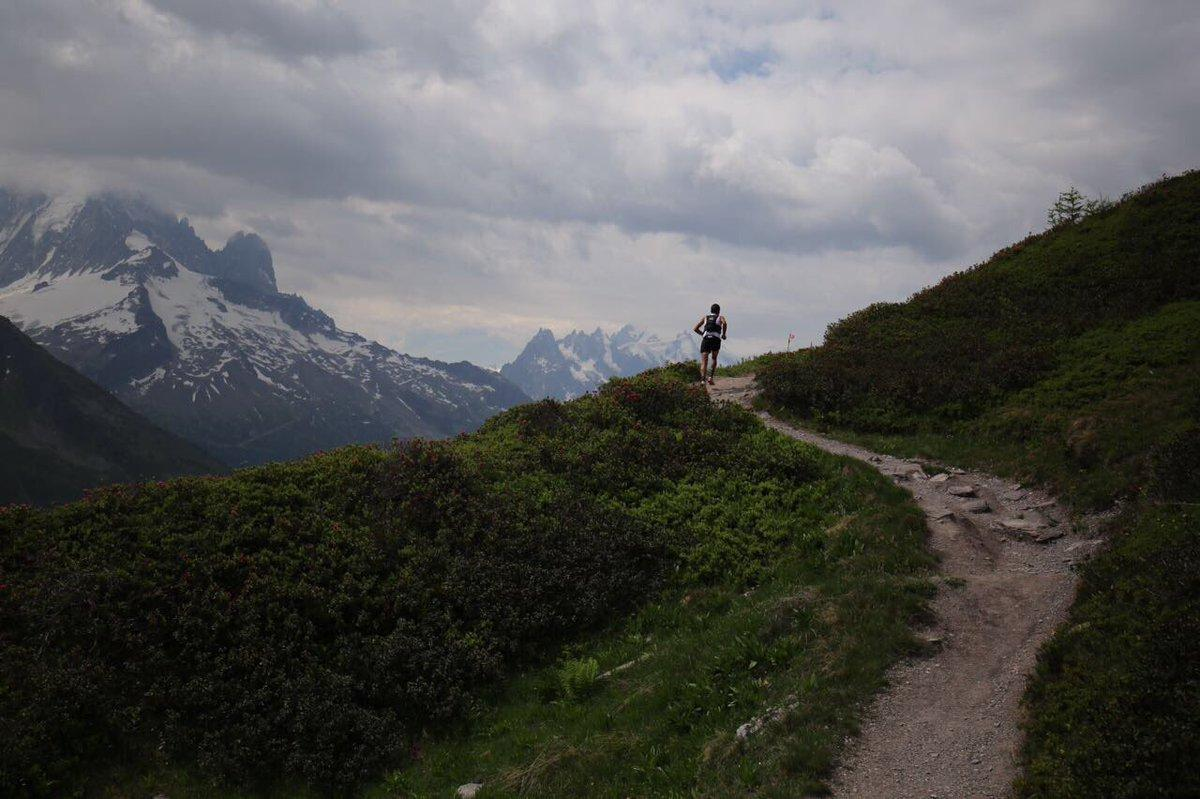

In [5]:
dev_data_path = "dataset/Informative/info_image_only_dev.json"
test_data_path = "dataset/Informative/info_image_only_test.json"
result_json_path = "test_results/Informative/Test-23/gpt-4o-Info-Zeroshot-Image-Only.json"

test_gpt(
    model_name="gpt-4o-2024-08-06",
    test_data_path=test_data_path,
    dev_data_path=dev_data_path,
    result_path=result_json_path,
    system_prompt=INFO_IMAGE_ONLY_SYSTEM_PROMPT,
    user_prompt=INFO_IMAGE_ONLY_USER_PROMPT,
    few_shot_num=0,
    consistency=True,
    use_text=False,   # or False if you want image-only
    use_image=True, # or True if you have images to pass
    label_key="label"
)

##### GPT 4o-mini

[{'role': 'system', 'content': 'You are an AI model that classifies the given text and image into one of two categories based on its informational value. Your task is to analyze the given text and image to determine whether they contains relevant or informative content about a crisis.\\n\\nOur goal is to collect as much useful information as possible about crises, so your classification should prioritize identifying texts and image that provide relevant details, even if they are brief or incomplete. Avoid being overly restrictive. If the text and image have any relevant crisis-related information, classify them as informative.\\n\\nClassify the text delimited by triple quotes (""" """) and the given image into one of the following categories:\\n\\n- **1 (positive):** The text and image provide details, updates, or any relevant information about a crisis.\\n\\n- **0 (not positive):** The text and image do not contain relevant details or information about a crisis.\\n\\nReturn only the c
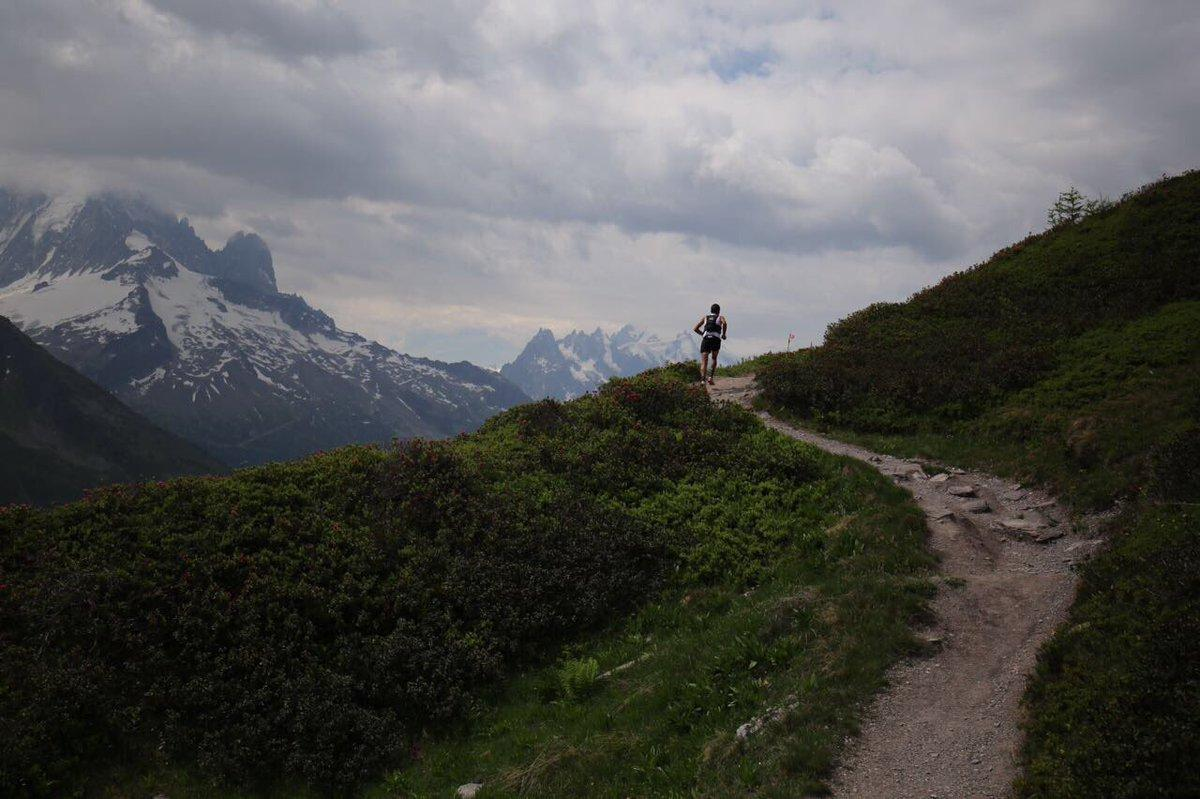

In [7]:
dev_data_path = "dataset/Informative/info_image_only_dev.json"
test_data_path = "dataset/Informative/info_image_only_test.json"
result_json_path = "test_results/Informative/Test-23/gpt-4o-mini-Info-Zeroshot-Image-Only.json"

test_gpt(
    model_name="gpt-4o-mini-2024-07-18",
    test_data_path=test_data_path,
    dev_data_path=dev_data_path,
    result_path=result_json_path,
    system_prompt=INFO_IMAGE_ONLY_SYSTEM_PROMPT,
    user_prompt=INFO_IMAGE_ONLY_USER_PROMPT,
    few_shot_num=0,
    consistency=True,
    use_text=False,   # or False if you want image-only
    use_image=True, # or True if you have images to pass
    label_key="label"
)

### Text Image

##### GPT 4o

[{'role': 'system', 'content': 'Classify the text delimited by triple quotes (""" """) in combination with the given image for crisis management. Determine if they provide important information that could help during a crisis.\\nReturn only a single classification label:\\n  1 if the text and image together provide useful crisis-related information.\\n  0 if the text and image together do not provide useful crisis-related information.\\nDo not include any extra text or explanation in your response.'}, {'role': 'user', 'content': [{'type': 'text', 'text': '\n    Classify the following text delimited by triple quotes (""" """) and image into one of the two categories:  \n        - 1 if the text and image provides details, updates, or any relevant information about a crisis.  \n        - 0 if the text and image does not contain relevant details or information about a crisis.\n\n\nText:\n    """\n        Cristofer CLEMENTE MORA now in 2nd at aguille du posettes. He\'s hunting âš¡ï¸\x8f #Mo
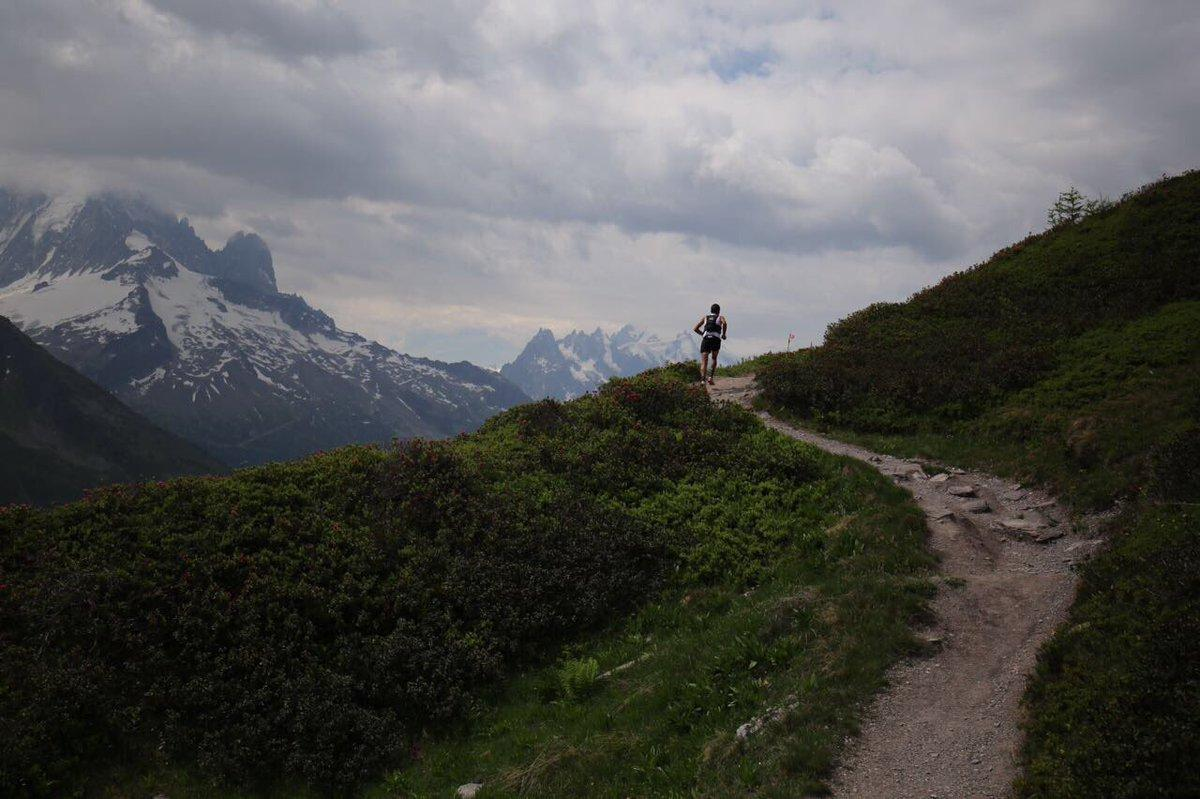

In [5]:
dev_data_path = "dataset/Informative/info_text_image_dev.json"
test_data_path = "dataset/Informative/info_text_image_test.json"
result_json_path = "test_results/Informative/Test-23/gpt-4o-Info-Zeroshot-Text-Image.json"

test_gpt(
    model_name="gpt-4o-2024-08-06",
    test_data_path=test_data_path,
    dev_data_path=dev_data_path,
    result_path=result_json_path,
    system_prompt=INFO_TEXT_IMAGE_SYSTEM_PROMPT,
    user_prompt=INFO_TEXT_IMAGE_USER_PROMPT,
    few_shot_num=0,
    consistency=True,
    use_text=True,   # or False if you want image-only
    use_image=True, # or True if you have images to pass
    label_key="label"
)

##### GPT 4o-mini

[{'role': 'system', 'content': 'Classify the text delimited by triple quotes (""" """) in combination with the given image for crisis management. Determine if they provide important information that could help during a crisis.\\nReturn only a single classification label:\\n  1 if the text and image together provide useful crisis-related information.\\n  0 if the text and image together do not provide useful crisis-related information.\\nDo not include any extra text or explanation in your response.'}, {'role': 'user', 'content': [{'type': 'text', 'text': '\n    Classify the following text delimited by triple quotes (""" """) and image into one of the two categories:  \n        - 1 if the text and image provides details, updates, or any relevant information about a crisis.  \n        - 0 if the text and image does not contain relevant details or information about a crisis.\n\n\nText:\n    """\n        Cristofer CLEMENTE MORA now in 2nd at aguille du posettes. He\'s hunting âš¡ï¸\x8f #Mo
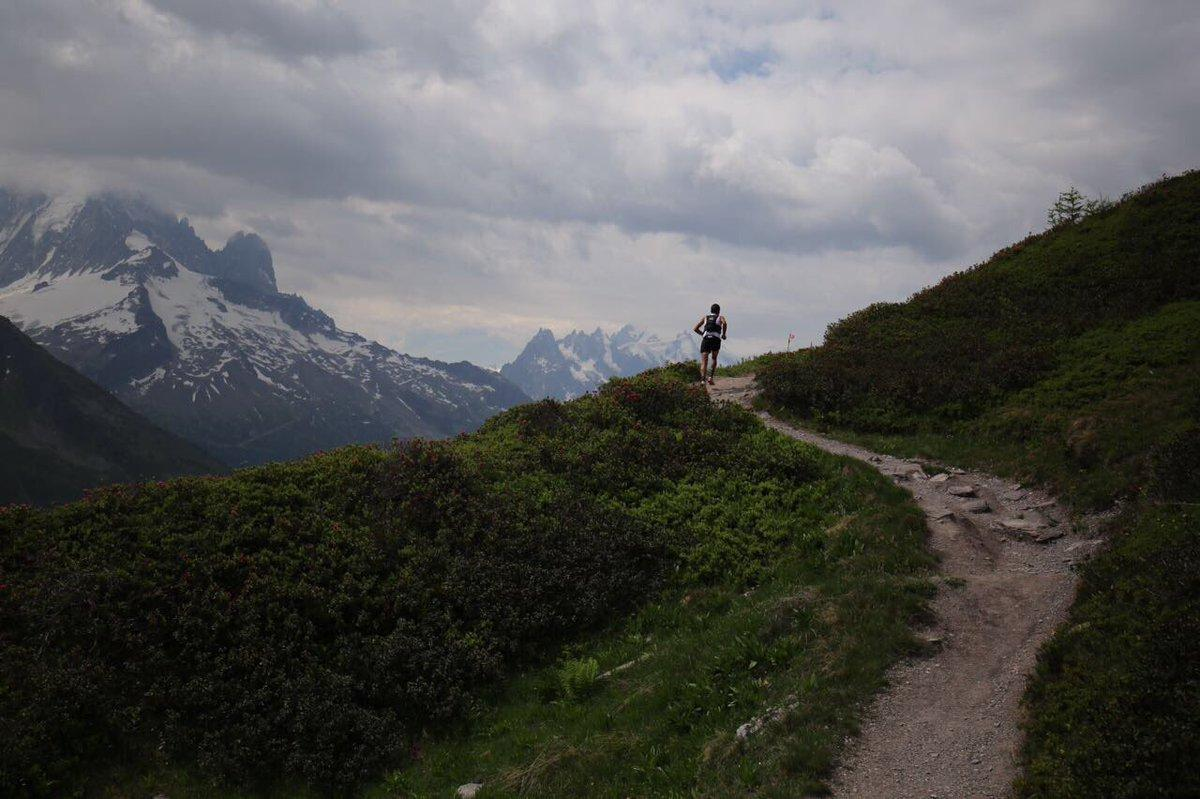

In [6]:
dev_data_path = "dataset/Informative/info_text_image_dev.json"
test_data_path = "dataset/Informative/info_text_image_test.json"
result_json_path = "test_results/Informative/Test-23/gpt-4o-mini-Info-Zeroshot-Text-Image.json"

test_gpt(
    model_name="gpt-4o-mini-2024-07-18",
    test_data_path=test_data_path,
    dev_data_path=dev_data_path,
    result_path=result_json_path,
    system_prompt=INFO_TEXT_IMAGE_SYSTEM_PROMPT,
    user_prompt=INFO_TEXT_IMAGE_USER_PROMPT,
    few_shot_num=0,
    consistency=True,
    use_text=True,   # or False if you want image-only
    use_image=True, # or True if you have images to pass
    label_key="label"
)

# GPT ONE SHOT - INFORMATIVE

### Text Only

##### GPT 4o

In [7]:
dev_data_path = "dataset/Informative/info_text_only_dev.json"
test_data_path = "dataset/Informative/info_text_only_test.json"
result_json_path = "test_results/Informative/Test-23/gpt-4o-Info-Oneshot-Text-Only.json"

test_gpt(
    model_name="gpt-4o-2024-08-06",
    test_data_path=test_data_path,
    dev_data_path=dev_data_path,
    result_path=result_json_path,
    system_prompt=INFO_TEXT_ONLY_SYSTEM_PROMPT,
    user_prompt=INFO_TEXT_ONLY_USER_PROMPT,
    few_shot_num=1,
    consistency=True,
    use_text=True,   # or False if you want image-only
    use_image=False, # or True if you have images to pass
    label_key="label"
)

[{'role': 'system', 'content': 'You are an AI model that classifies text into one of two categories based on its informational value. Your task is to analyze the given text and determine whether it contains relevant or informative content about a crisis.\\n\\nOur goal is to collect as much useful information as possible about crises, so your classification should prioritize identifying texts that provide relevant details, even if they are brief or incomplete. Avoid being overly restrictive. If a text has any relevant crisis-related information, classify it as informative.\\n\\nClassify the text delimited by triple quotes (""" """) into one of the following categories:\\n\\n- **1 (positive):** The text provides details, updates, or any relevant information about a crisis.\\n\\n- **0 (not positive):** The text does not contain relevant details or information about a crisis.\\n\\nReturn only the classification label (1 or 0) without any extra text or explanation.'}, {'role': 'user', 'cont

##### GPT 4o-mini

In [6]:
dev_data_path = "dataset/Informative/info_text_only_dev.json"
test_data_path = "dataset/Informative/info_text_only_test.json"
result_json_path = "test_results/Informative/Test-23/gpt-4o-mini-Info-Oneshot-Text-Only.json"

test_gpt(
    model_name="gpt-4o-mini-2024-07-18",
    test_data_path=test_data_path,
    dev_data_path=dev_data_path,
    result_path=result_json_path,
    system_prompt=INFO_TEXT_ONLY_SYSTEM_PROMPT,
    user_prompt=INFO_TEXT_ONLY_USER_PROMPT,
    few_shot_num=1,
    consistency=True,
    use_text=True,   # or False if you want image-only
    use_image=False, # or True if you have images to pass
    label_key="label"
)

[{'role': 'system', 'content': 'You are an AI model that classifies text into one of two categories based on its informational value. Your task is to analyze the given text and determine whether it contains relevant or informative content about a crisis.\\n\\nOur goal is to collect as much useful information as possible about crises, so your classification should prioritize identifying texts that provide relevant details, even if they are brief or incomplete. Avoid being overly restrictive. If a text has any relevant crisis-related information, classify it as informative.\\n\\nClassify the text delimited by triple quotes (""" """) into one of the following categories:\\n\\n- **1 (positive):** The text provides details, updates, or any relevant information about a crisis.\\n\\n- **0 (not positive):** The text does not contain relevant details or information about a crisis.\\n\\nReturn only the classification label (1 or 0) without any extra text or explanation.'}, {'role': 'user', 'cont

### Image Only

##### GPT 4o

[{'role': 'system', 'content': 'You are an AI model that classifies the given text and image into one of two categories based on its informational value. Your task is to analyze the given text and image to determine whether they contains relevant or informative content about a crisis.\\n\\nOur goal is to collect as much useful information as possible about crises, so your classification should prioritize identifying texts and image that provide relevant details, even if they are brief or incomplete. Avoid being overly restrictive. If the text and image have any relevant crisis-related information, classify them as informative.\\n\\nClassify the text delimited by triple quotes (""" """) and the given image into one of the following categories:\\n\\n- **1 (positive):** The text and image provide details, updates, or any relevant information about a crisis.\\n\\n- **0 (not positive):** The text and image do not contain relevant details or information about a crisis.\\n\\nReturn only the c
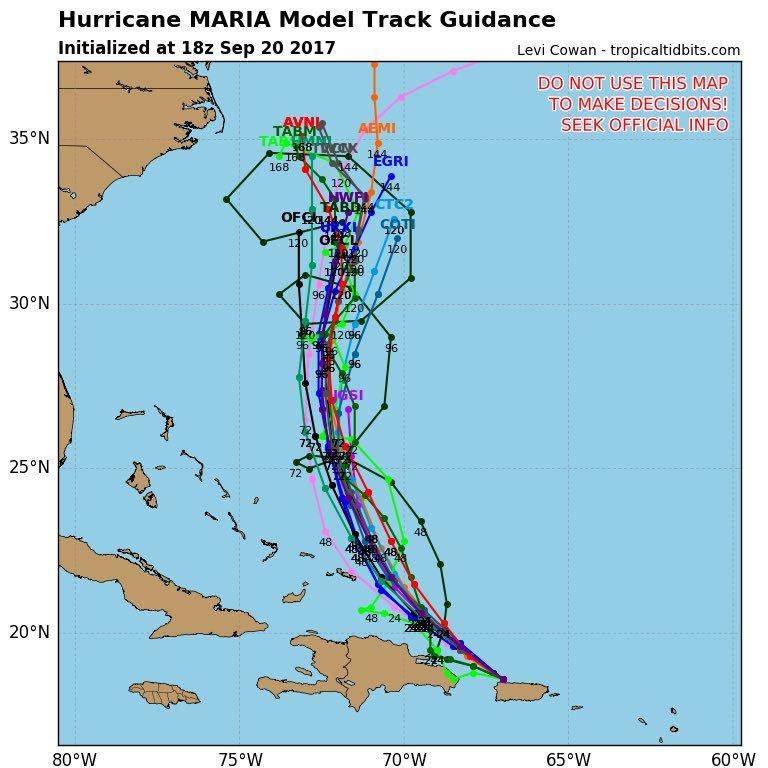
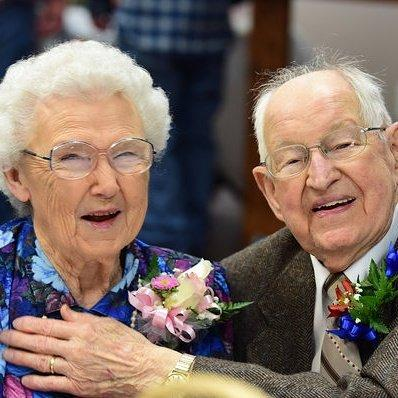
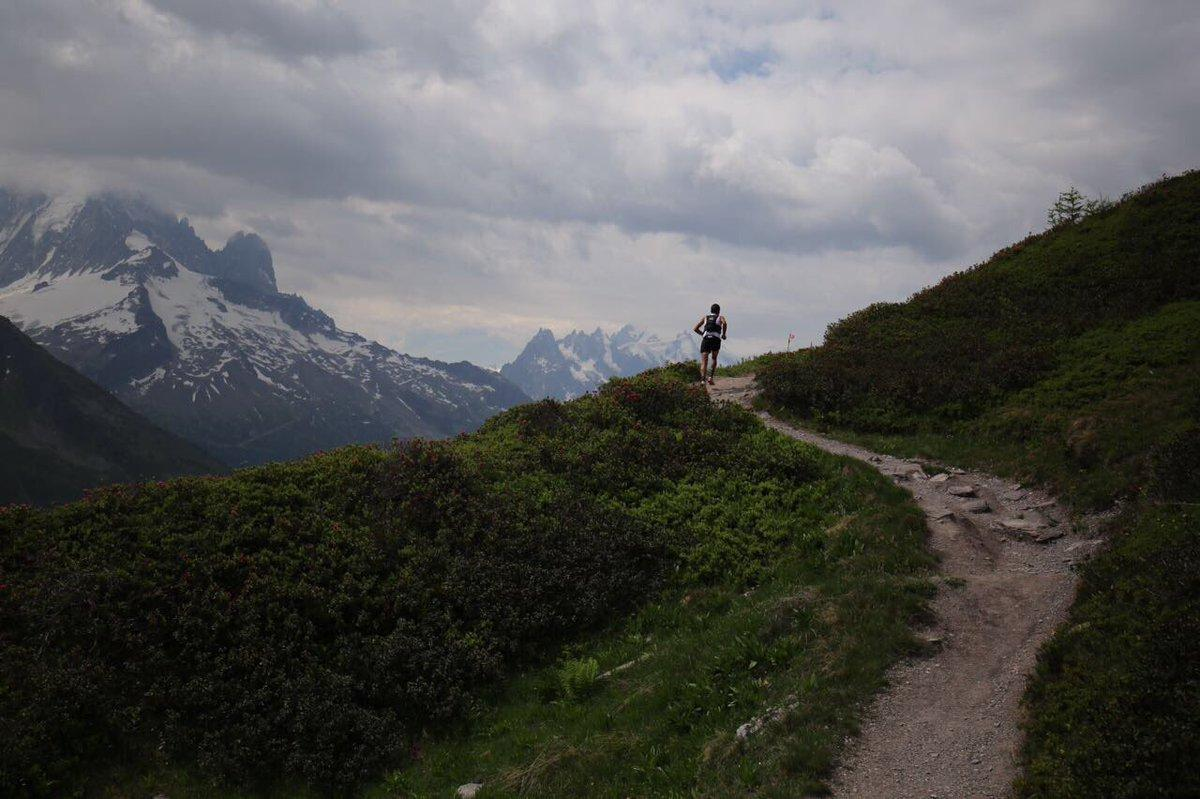

In [7]:
dev_data_path = "dataset/Informative/info_image_only_dev.json"
test_data_path = "dataset/Informative/info_image_only_test.json"
result_json_path = "test_results/Informative/Test-23/gpt-4o-Info-Oneshot-Image-Only.json"

test_gpt(
    model_name="gpt-4o-2024-08-06",
    test_data_path=test_data_path,
    dev_data_path=dev_data_path,
    result_path=result_json_path,
    system_prompt=INFO_IMAGE_ONLY_SYSTEM_PROMPT,
    user_prompt=INFO_IMAGE_ONLY_USER_PROMPT,
    few_shot_num=1,
    consistency=True,
    use_text=False,   # or False if you want image-only
    use_image=True, # or True if you have images to pass
    label_key="label"
)

##### GPT 4o-mini

[{'role': 'system', 'content': 'You are an AI model that classifies the given text and image into one of two categories based on its informational value. Your task is to analyze the given text and image to determine whether they contains relevant or informative content about a crisis.\\n\\nOur goal is to collect as much useful information as possible about crises, so your classification should prioritize identifying texts and image that provide relevant details, even if they are brief or incomplete. Avoid being overly restrictive. If the text and image have any relevant crisis-related information, classify them as informative.\\n\\nClassify the text delimited by triple quotes (""" """) and the given image into one of the following categories:\\n\\n- **1 (positive):** The text and image provide details, updates, or any relevant information about a crisis.\\n\\n- **0 (not positive):** The text and image do not contain relevant details or information about a crisis.\\n\\nReturn only the c
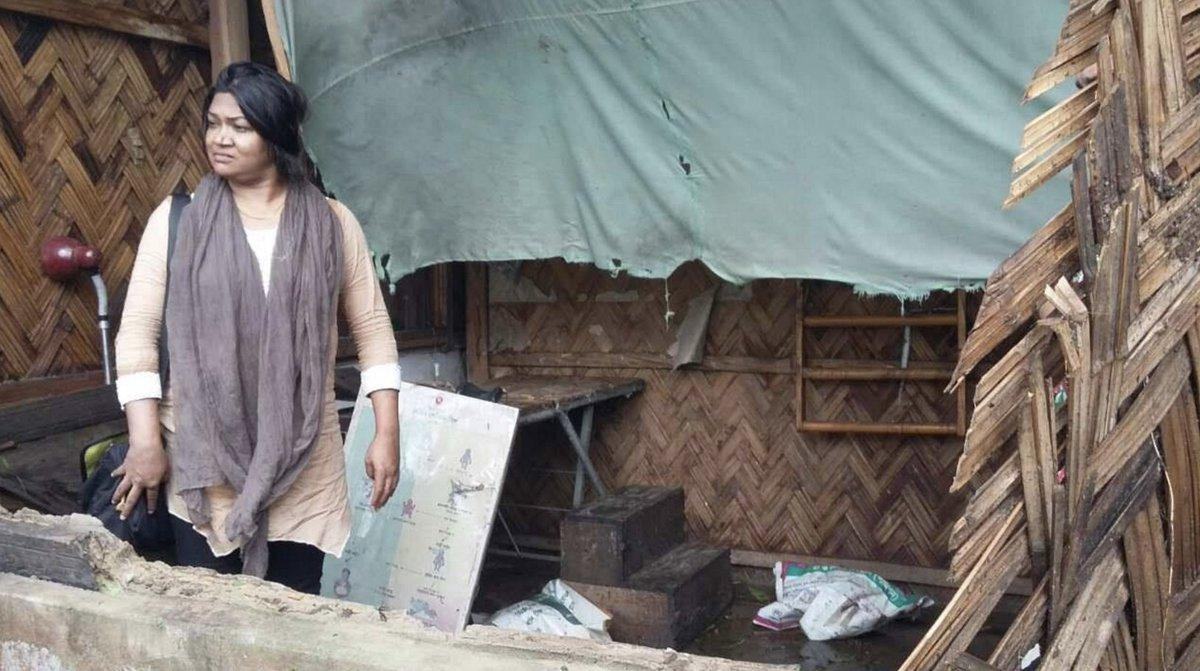
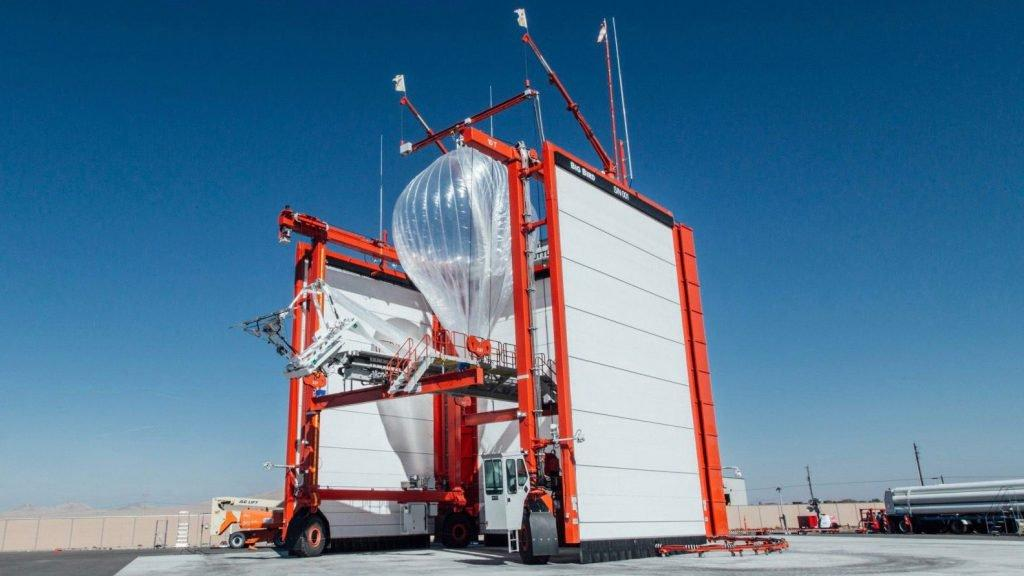
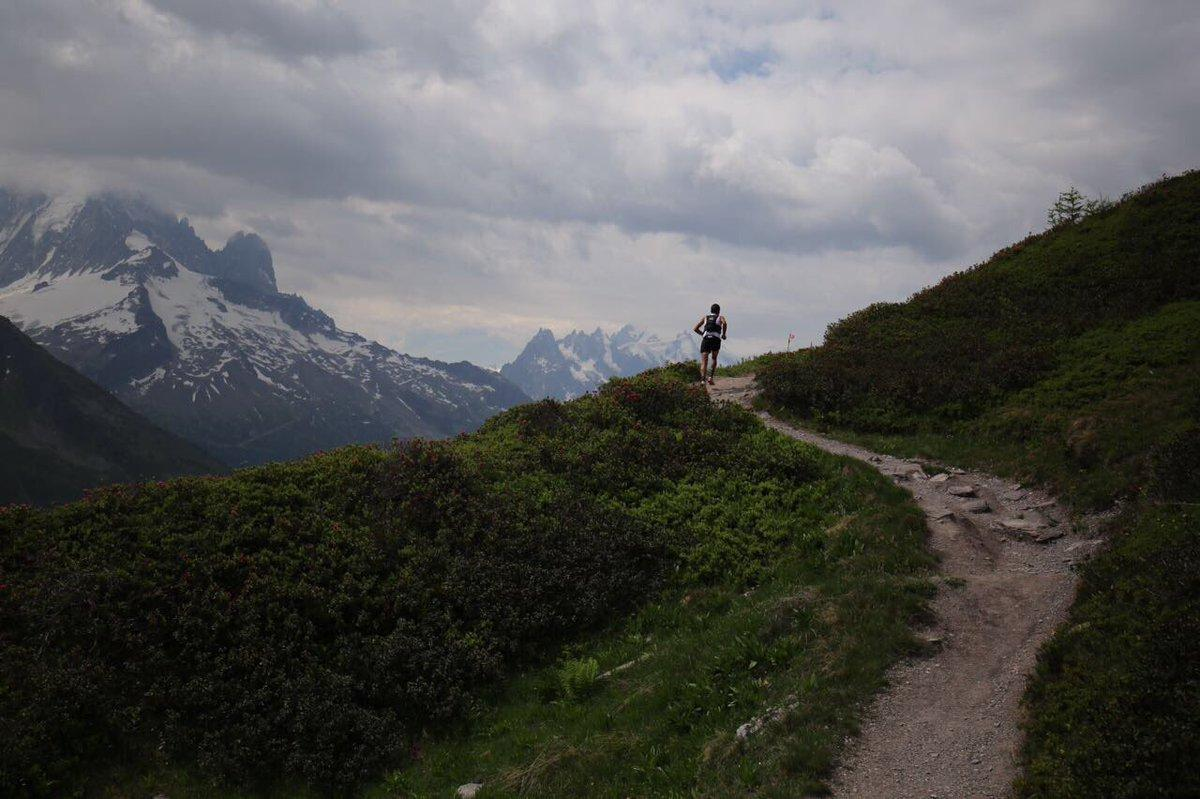

In [8]:
dev_data_path = "dataset/Informative/info_image_only_dev.json"
test_data_path = "dataset/Informative/info_image_only_test.json"
result_json_path = "test_results/Informative/Test-23/gpt-4o-mini-Info-Oneshot-Image-Only.json"

test_gpt(
    model_name="gpt-4o-mini-2024-07-18",
    test_data_path=test_data_path,
    dev_data_path=dev_data_path,
    result_path=result_json_path,
    system_prompt=INFO_IMAGE_ONLY_SYSTEM_PROMPT,
    user_prompt=INFO_IMAGE_ONLY_USER_PROMPT,
    few_shot_num=1,
    consistency=True,
    use_text=False,   # or False if you want image-only
    use_image=True, # or True if you have images to pass
    label_key="label"
)

### Text Image

##### GPT 4o

[{'role': 'system', 'content': 'Classify the text delimited by triple quotes (""" """) in combination with the given image for crisis management. Determine if they provide important information that could help during a crisis.\\nReturn only a single classification label:\\n  1 if the text and image together provide useful crisis-related information.\\n  0 if the text and image together do not provide useful crisis-related information.\\nDo not include any extra text or explanation in your response.'}, {'role': 'user', 'content': [{'type': 'text', 'text': '\n    Classify the following text delimited by triple quotes (""" """) and image into one of the two categories:  \n        - 1 if the text and image provides details, updates, or any relevant information about a crisis.  \n        - 0 if the text and image does not contain relevant details or information about a crisis.\n\n\n"""Hurricane Maria\'s effect on US not ruled out, forecasters say https://t.co/Ujd1s3Td2q https://t.co/Cjwrqbh
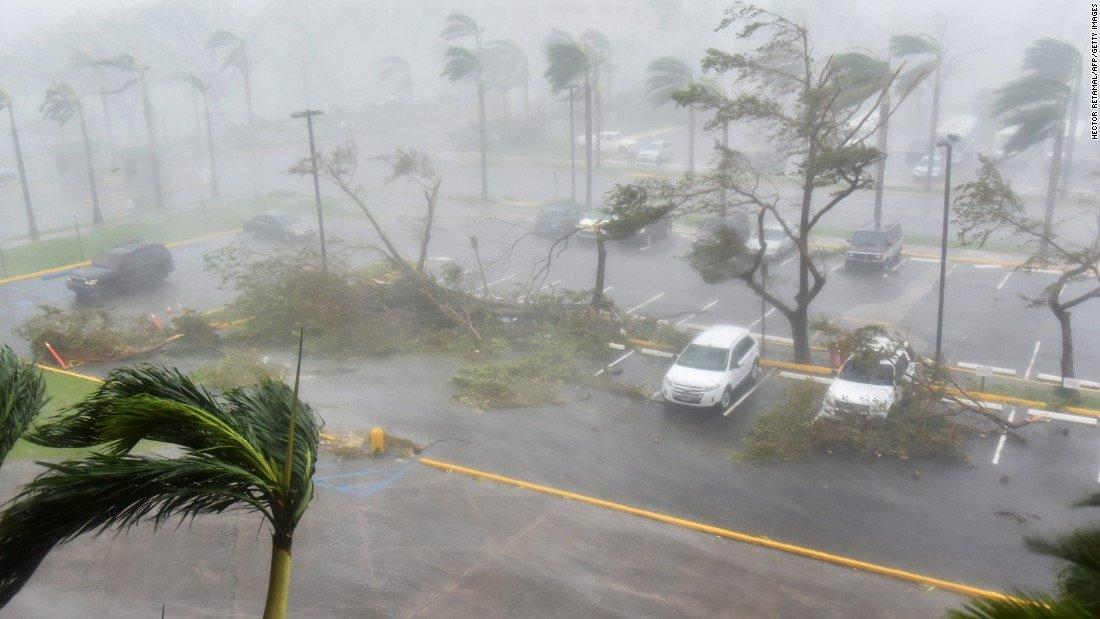
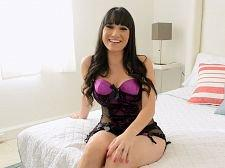
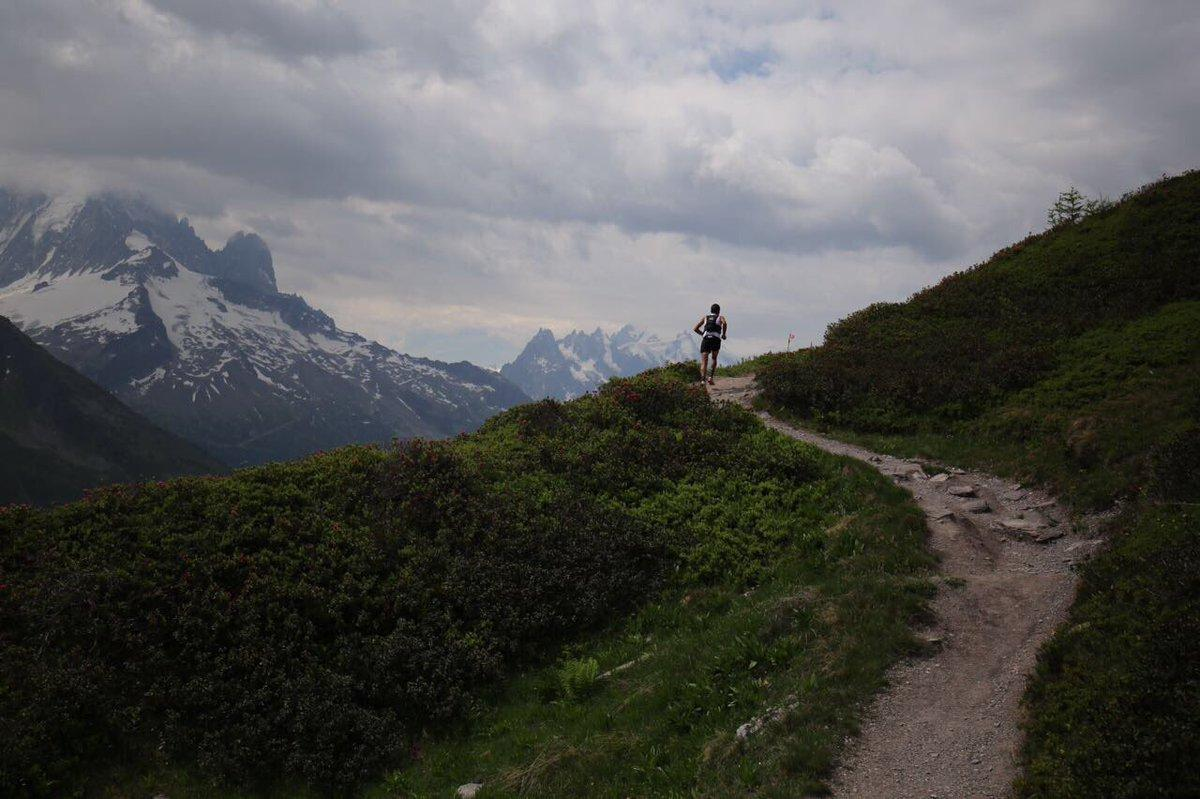

In [9]:
dev_data_path = "dataset/Informative/info_text_image_dev.json"
test_data_path = "dataset/Informative/info_text_image_test.json"
result_json_path = "test_results/Informative/Test-23/gpt-4o-Info-Oneshot-Text-Image.json"

test_gpt(
    model_name="gpt-4o-2024-08-06",
    test_data_path=test_data_path,
    dev_data_path=dev_data_path,
    result_path=result_json_path,
    system_prompt=INFO_TEXT_IMAGE_SYSTEM_PROMPT,
    user_prompt=INFO_TEXT_IMAGE_USER_PROMPT,
    few_shot_num=1,
    consistency=True,
    use_text=True,   # or False if you want image-only
    use_image=True, # or True if you have images to pass
    label_key="label"
)

##### GPT 4o-mini

[{'role': 'system', 'content': 'Classify the text delimited by triple quotes (""" """) in combination with the given image for crisis management. Determine if they provide important information that could help during a crisis.\\nReturn only a single classification label:\\n  1 if the text and image together provide useful crisis-related information.\\n  0 if the text and image together do not provide useful crisis-related information.\\nDo not include any extra text or explanation in your response.'}, {'role': 'user', 'content': [{'type': 'text', 'text': '\n    Classify the following text delimited by triple quotes (""" """) and image into one of the two categories:  \n        - 1 if the text and image provides details, updates, or any relevant information about a crisis.  \n        - 0 if the text and image does not contain relevant details or information about a crisis.\n\n\n"""South Florida peeps! We need volunteers #HurricaneMaria #PuertoRico https://t.co/p2BnkpKzmO"""'}, {'type': 
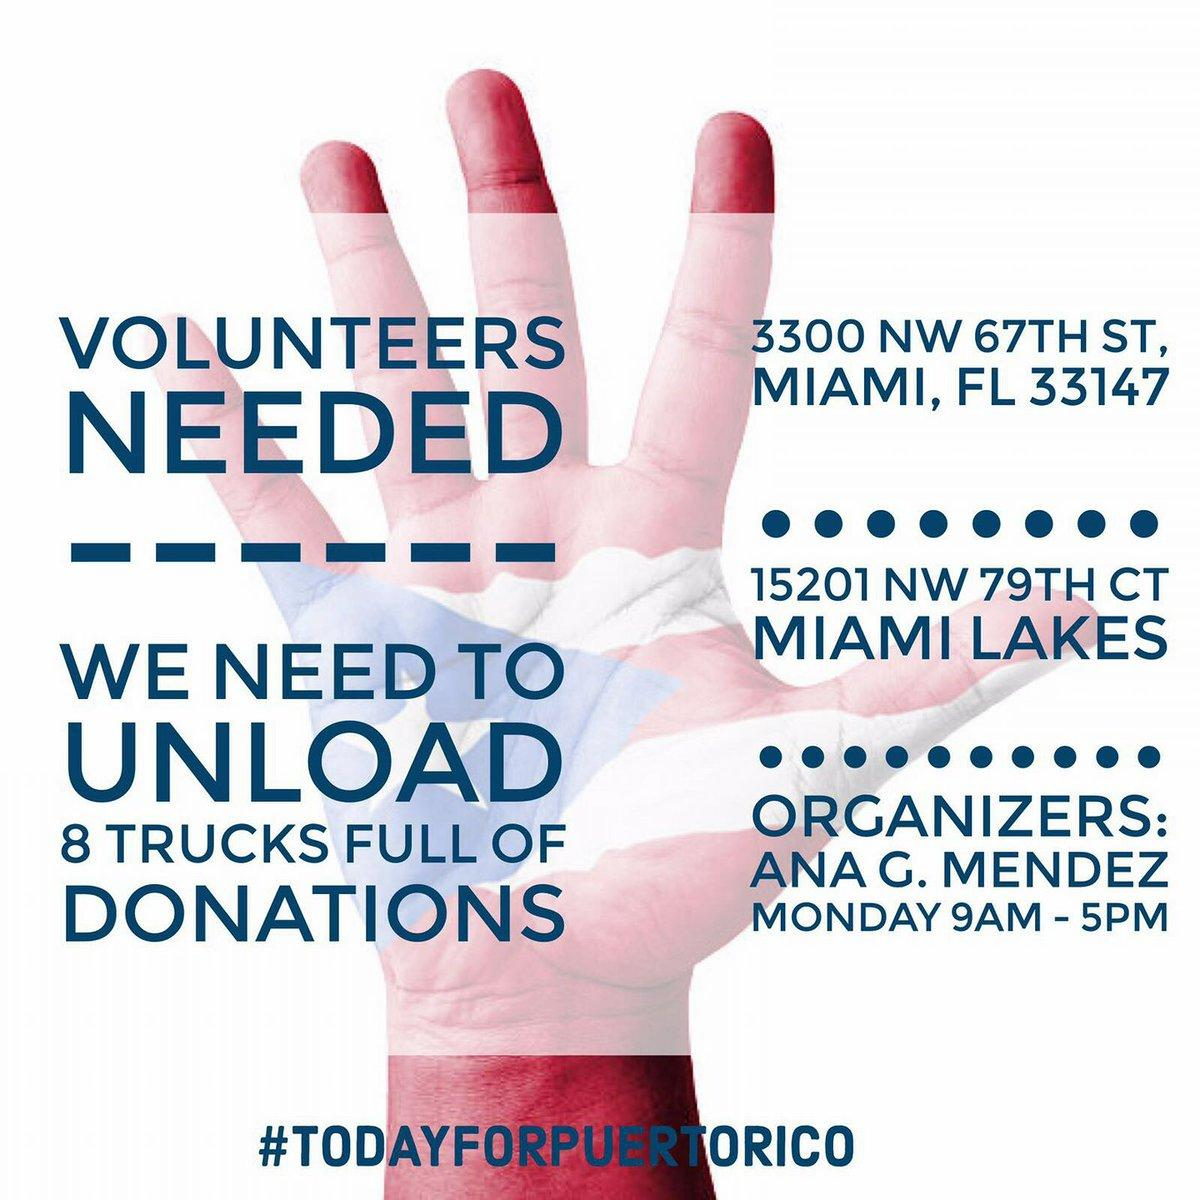
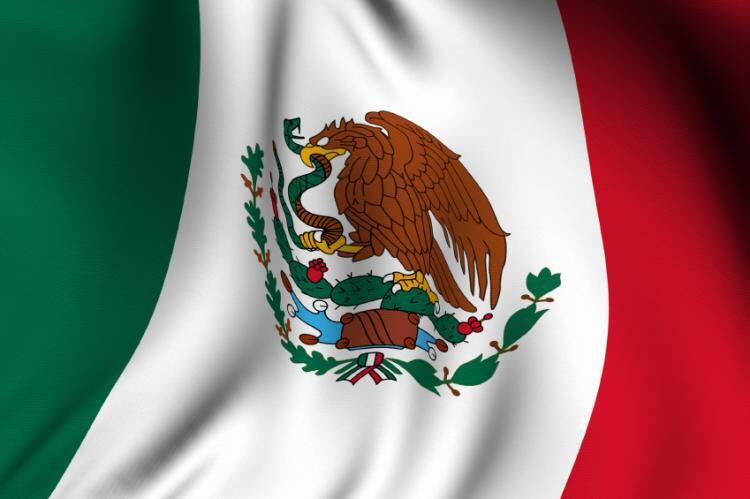
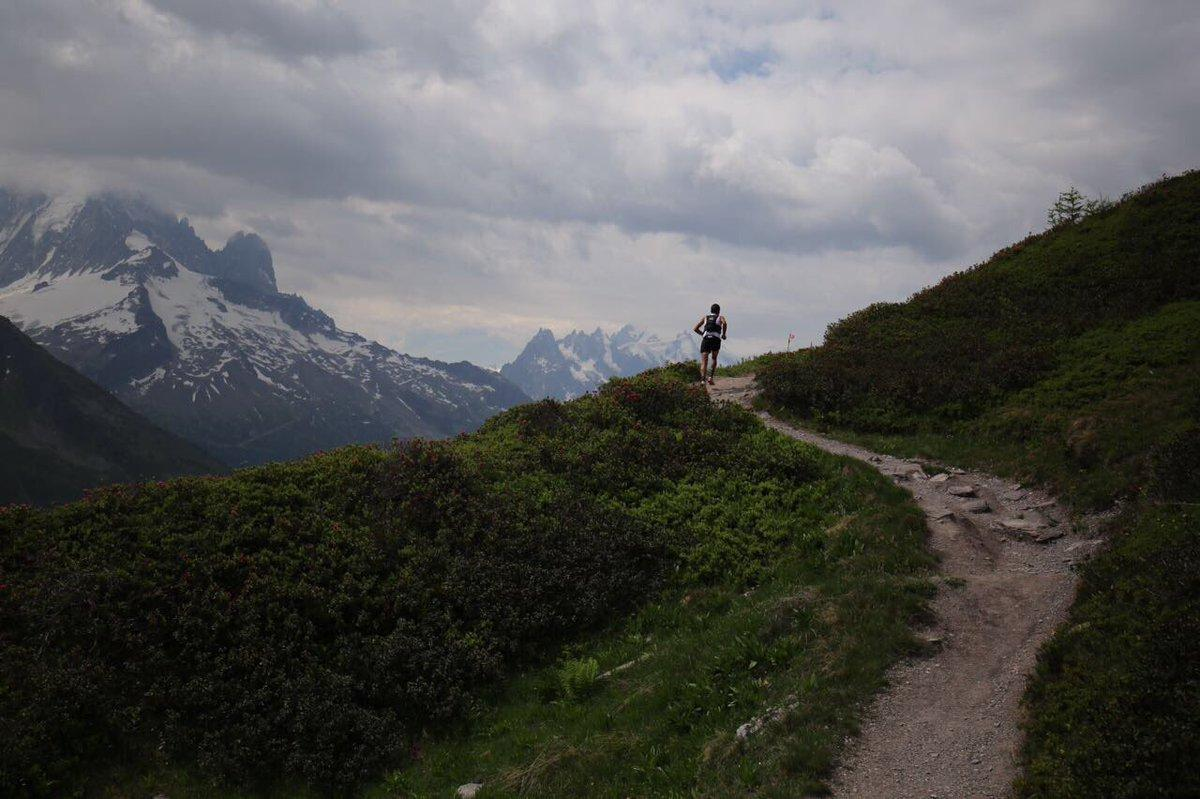

In [10]:
dev_data_path = "dataset/Informative/info_text_image_dev.json"
test_data_path = "dataset/Informative/info_text_image_test.json"
result_json_path = "test_results/Informative/Test-23/gpt-4o-mini-Info-Oneshot-Text-Image.json"

test_gpt(
    model_name="gpt-4o-mini-2024-07-18",
    test_data_path=test_data_path,
    dev_data_path=dev_data_path,
    result_path=result_json_path,
    system_prompt=INFO_TEXT_IMAGE_SYSTEM_PROMPT,
    user_prompt=INFO_TEXT_IMAGE_USER_PROMPT,
    few_shot_num=1,
    consistency=True,
    use_text=True,   # or False if you want image-only
    use_image=True, # or True if you have images to pass
    label_key="label"
)